In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

sns.set(style="whitegrid", font_scale=1.1)

RANDOM_STATE = 42
BASE = Path(".").resolve()


In [2]:
data_path = BASE / "data" / "processed" / "creditcard_clean.csv"
print("Temiz veri yolu:", data_path)

df = pd.read_csv(data_path)
print("Veri boyutu:", df.shape)
df.head()


Temiz veri yolu: C:\Users\Administrator\Desktop\fraud-detection-win-ar\data\processed\creditcard_clean.csv
Veri boyutu: (283726, 33)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_scaled,Time_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244200,-1.996823
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342584,-1.996823
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.158900,-1.996802
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.139886,-1.996802
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073813,-1.996781


In [3]:
target_col = "Class"  

X = df.drop(columns=[target_col])
y = df[target_col]

print("X şekli:", X.shape)
print("y şekli:", y.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Eğitim seti:", X_train.shape, y_train.shape)
print("Test seti  :", X_test.shape, y_test.shape)


X şekli: (283726, 32)
y şekli: (283726,)
Eğitim seti: (226980, 32) (226980,)
Test seti  : (56746, 32) (56746,)


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

print("Baseline (LogReg) modeli eğitiliyor...")
baseline_pipe.fit(X_train, y_train)
print("Eğitim tamamlandı.")


Baseline (LogReg) modeli eğitiliyor...
Eğitim tamamlandı.


In [5]:
y_pred = baseline_pipe.predict(X_test)
y_proba = baseline_pipe.predict_proba(X_test)[:, 1]

print("=== Baseline Logistic Regression – Sınıflandırma Raporu ===\n")
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

print(f"ROC-AUC skoru: {roc_auc:.4f}")
print(f"Average Precision (PR AUC): {avg_prec:.4f}")


=== Baseline Logistic Regression – Sınıflandırma Raporu ===

              precision    recall  f1-score   support

           0     0.9998    0.9755    0.9875     56651
           1     0.0564    0.8737    0.1060        95

    accuracy                         0.9753     56746
   macro avg     0.5281    0.9246    0.5467     56746
weighted avg     0.9982    0.9753    0.9860     56746

ROC-AUC skoru: 0.9657
Average Precision (PR AUC): 0.6738


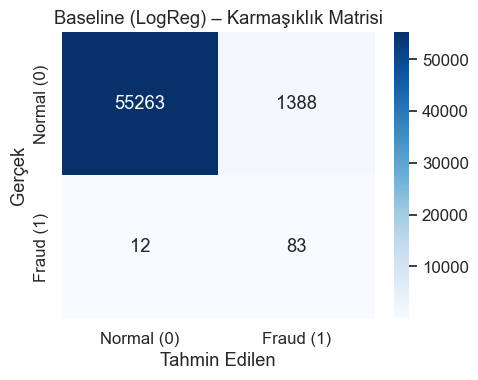

In [6]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal (0)", "Fraud (1)"],
    yticklabels=["Normal (0)", "Fraud (1)"]
)
plt.title("Baseline (LogReg) – Karmaşıklık Matrisi")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.show()


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_recall_curve, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]   

print(classification_report(y_test, y_pred))

os.makedirs("outputs/figures", exist_ok=True)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Baseline Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.savefig("outputs/figures/baseline_confusion.png", dpi=300)
plt.close()


fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Baseline Logistic Regression - ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("outputs/figures/baseline_roc.png", dpi=300)
plt.close()


precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Baseline Logistic Regression - Precision-Recall Curve")
plt.tight_layout()
plt.savefig("outputs/figures/baseline_pr.png", dpi=300)
plt.close()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.85      0.56      0.68        95

    accuracy                           1.00     56746
   macro avg       0.93      0.78      0.84     56746
weighted avg       1.00      1.00      1.00     56746



In [8]:
import json

reports_dir = BASE / "outputs" / "reports"
reports_dir.mkdir(parents=True, exist_ok=True)

cls_report = classification_report(y_test, y_pred, output_dict=True)

metrics = {
    "model_name": "baseline_logreg",
    "roc_auc": roc_auc,
    "average_precision": avg_prec,
    "classification_report": cls_report
}

out_json = reports_dir / "baseline_logreg_metrics.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=4, ensure_ascii=False)

print("Baseline metrikleri kaydedildi →", out_json)


Baseline metrikleri kaydedildi → C:\Users\Administrator\Desktop\fraud-detection-win-ar\outputs\reports\baseline_logreg_metrics.json


In [9]:
import numpy as np
import os

# klasör garantile
os.makedirs("outputs/reports", exist_ok=True)

# y_test, y_pred, y_prob burada zaten tanımlı olmalı
np.save("outputs/reports/baseline_y_test.npy",  y_test)
np.save("outputs/reports/baseline_y_pred.npy",  y_pred)
np.save("outputs/reports/baseline_y_prob.npy",  y_prob)

print("Baseline tahminleri kaydedildi (outputs/reports/...).")


Baseline tahminleri kaydedildi (outputs/reports/...).
